In [2]:
import pm4py
import pandas as pd
import numpy as np

# pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 200

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
log = pd.read_csv("abstract_log-starts_ends-cov_var_75perc.csv")
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])

## Method 2: frequent - simult

In [6]:
# TODO
# - frequent itemsets for all case events (trace = transaction)
# - for each itemset, check how many have the same timestamps
# (have some leeway for almost-identical timestamps)

In [7]:
log2 = log[(log['concept:name'].str.contains("Candidate")) | log['concept:name'].str.contains("Integrated")]
log2

,Unnamed: 0,case:concept:name,concept:name,time:timestamp
10,10,1,Candidate Search:start,2024-06-03 09:20:48
11,11,1,Integrated Search:start,2024-06-03 09:20:48
12,12,1,Integrated Search:end,2024-06-03 09:20:54
13,13,1,Candidate ID:start,2024-06-03 09:20:55
14,14,1,Candidate ID Decision:start,2024-06-03 09:20:55
...,...,...,...,...
244782,328789,998,Candidate ID Decision:start,2024-06-04 05:52:04
244783,328790,998,Candidate Search:end,2024-06-04 05:52:04
244784,328791,998,Integrated Search:end,2024-06-04 05:52:04
244785,328792,998,Candidate ID:end,2024-06-04 05:52:06


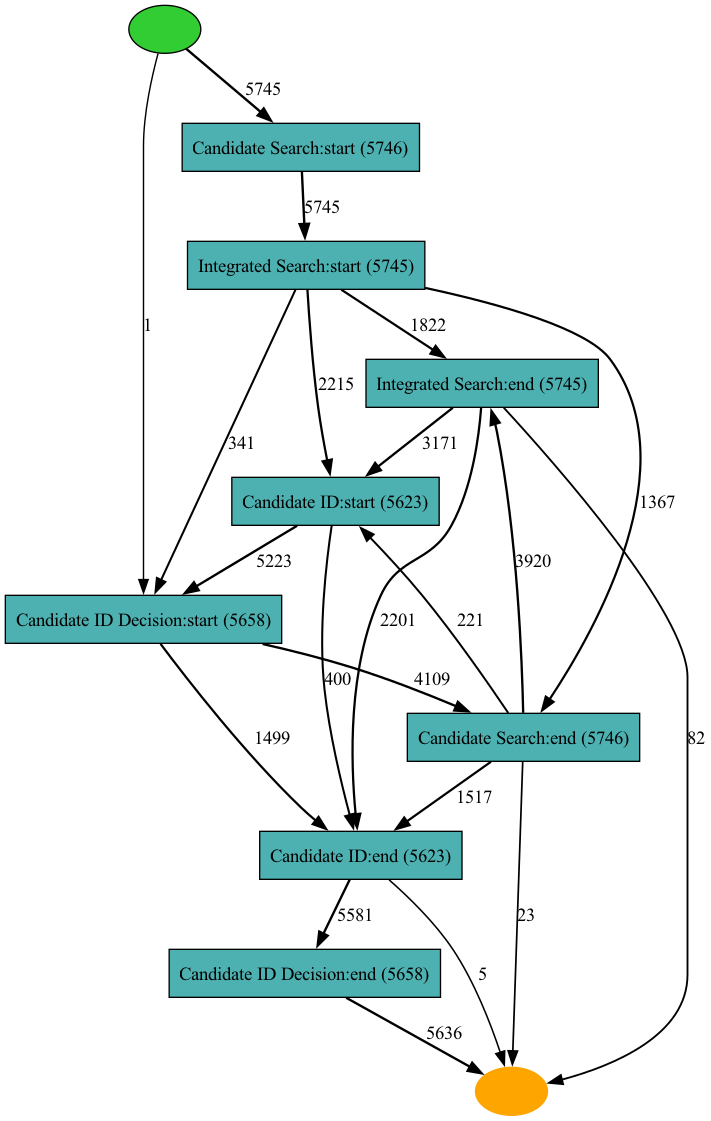

In [46]:
from mine_utils import mine_heur
mine_heur(log2)

In [8]:
traces = log2.groupby('case:concept:name')['concept:name'].apply(tuple).to_list()
traces

[('Candidate Search:start',
  'Integrated Search:start',
  'Integrated Search:end',
  'Candidate ID:start',
  'Candidate ID Decision:start',
  'Candidate Search:end',
  'Candidate ID:end',
  'Candidate ID Decision:end'),
 ('Candidate Search:start',
  'Integrated Search:start',
  'Integrated Search:end',
  'Candidate ID:start',
  'Candidate ID Decision:start',
  'Candidate Search:end',
  'Candidate ID:end',
  'Candidate ID Decision:end'),
 ('Candidate Search:start',
  'Integrated Search:start',
  'Candidate ID:start',
  'Candidate ID Decision:start',
  'Candidate Search:end',
  'Integrated Search:end',
  'Candidate ID:end',
  'Candidate ID Decision:end'),
 ('Candidate Search:start',
  'Integrated Search:start',
  'Candidate ID:start',
  'Candidate ID Decision:start',
  'Candidate Search:end',
  'Integrated Search:end',
  'Candidate ID:end',
  'Candidate ID Decision:end'),
 ('Candidate Search:start',
  'Integrated Search:start',
  'Candidate ID:start',
  'Candidate ID Decision:start',
  

In [9]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(traces).transform(traces)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,Candidate ID Decision:end,Candidate ID Decision:start,Candidate ID:end,Candidate ID:start,Candidate Search:end,Candidate Search:start,Integrated Search:end,Integrated Search:start
0,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...
5741,True,True,True,True,True,True,True,True
5742,True,True,True,True,True,True,True,True
5743,True,True,True,True,True,True,True,True
5744,True,True,True,True,True,True,True,True


In [ ]:
from mlxtend.frequent_patterns import apriori, fpgrowth

# itemsets = apriori(df, min_support=0.5, use_colnames=True)
itemsets = fpgrowth(df, min_support=0.6, use_colnames=True)
itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
itemsets = itemsets[itemsets['length'] >= 2]
# itemsets.to_csv("itemsets-method2.csv")
itemsets

,support,itemsets,length
8,1.000000,"(Candidate Search:start, Candidate Search:end)",2
9,0.999826,"(Integrated Search:start, Candidate Search:end)",2
10,0.999826,"(Integrated Search:start, Candidate Search:start)",2
11,0.999826,"(Integrated Search:start, Candidate Search:start, Candidate Search:end)",3
12,0.999826,"(Integrated Search:start, Integrated Search:end)",2
...,...,...,...
250,0.978420,"(Candidate ID Decision:start, Candidate ID:end, Integrated Search:start, Candidate Search:start, Candidate ID:start, Integrated Search:end, Candidate ID Decision:end)",7
251,0.978420,"(Candidate ID:end, Integrated Search:start, Candidate Search:start, Candidate ID:start, Integrated Search:end, Candidate ID Decision:end, Candidate Search:end)",7
252,0.978420,"(Candidate ID Decision:start, Candidate ID:end, Integrated Search:start, Candidate Search:start, Candidate ID:start, Integrated Search:end, Candidate Search:end)",7
253,0.978420,"(Candidate ID Decision:start, Candidate ID:end, Integrated Search:start, Candidate Search:start, Integrated Search:end, Candidate ID Decision:end, Candidate Search:end)",7


In [14]:
itemset = itemsets['itemsets'].iloc[-1]
itemset

frozenset({'Candidate ID Decision:end',
           'Candidate ID Decision:start',
           'Candidate ID:end',
           'Candidate ID:start',
           'Candidate Search:end',
           'Candidate Search:start',
           'Integrated Search:end',
           'Integrated Search:start'})

In [56]:
from mine_utils import aggregate_events

# itemset = ('Integrated Search:end', 'Candidate Search:end')
# 13,0.9998259658893143,"frozenset({'Candidate Search:end', 'Integrated Search:end'})",2
# groups: 5746 total size: 11491 avg size: 1.9998259658893143
# groups: 5746 # simult: 5746 avg: 100.0 %
# groups: 5746 avg_diff: 1980 s ( 33 m )
# {('Integrated Search:end', 'Candidate Search:end'): 0, ('Candidate Search:end', 'Integrated Search:end'): 0}

# itemset = ('Candidate ID Decision:end','Candidate ID Decision:start','Candidate ID:end','Candidate ID:start','Candidate Search:end','Candidate Search:start','Integrated Search:end','Integrated Search:start')
# groups: 5746 total size: 45544 avg size: 7.93
# groups: 5746 # simult: 4349 avg: 75.69 %
# groups: 5746 avg_diff: 23314 s ( 388 m )

# for itemset in itemsets['itemsets']:
#     print(itemset)
max_timedelta = 10 * 60 # * pow(10,9) # nano to seconds
log3 = aggregate_events(log2, itemset, max_timedelta)

# print()

# 'Integrated Search:end' -> 'Candidate Search:end'

5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
# groups: 5746 total size: 45544 avg size: 7.93
# groups: 5746 # simult: 4349 avg: 75.69 %
# groups: 5746 avg_diff: 23314 s ( 388 m )
{('Candidate ID Decision:end', 'Integrated Search:start'): 0, ('Integrated Search:start', 'Candidate ID Decision:end'): 0}


In [57]:
log3 = log3.sort_values(by=['case:concept:name', 'time:timestamp'])

In [44]:
diff = log3[log3['concept:name'].isin(itemset)].groupby('case:concept:name')['time:timestamp'].diff().astype(int)
diff = diff / pow(10, 9)
diff[(diff > 0) & (diff != 1)]

Series([], Name: time:timestamp, dtype: float64)

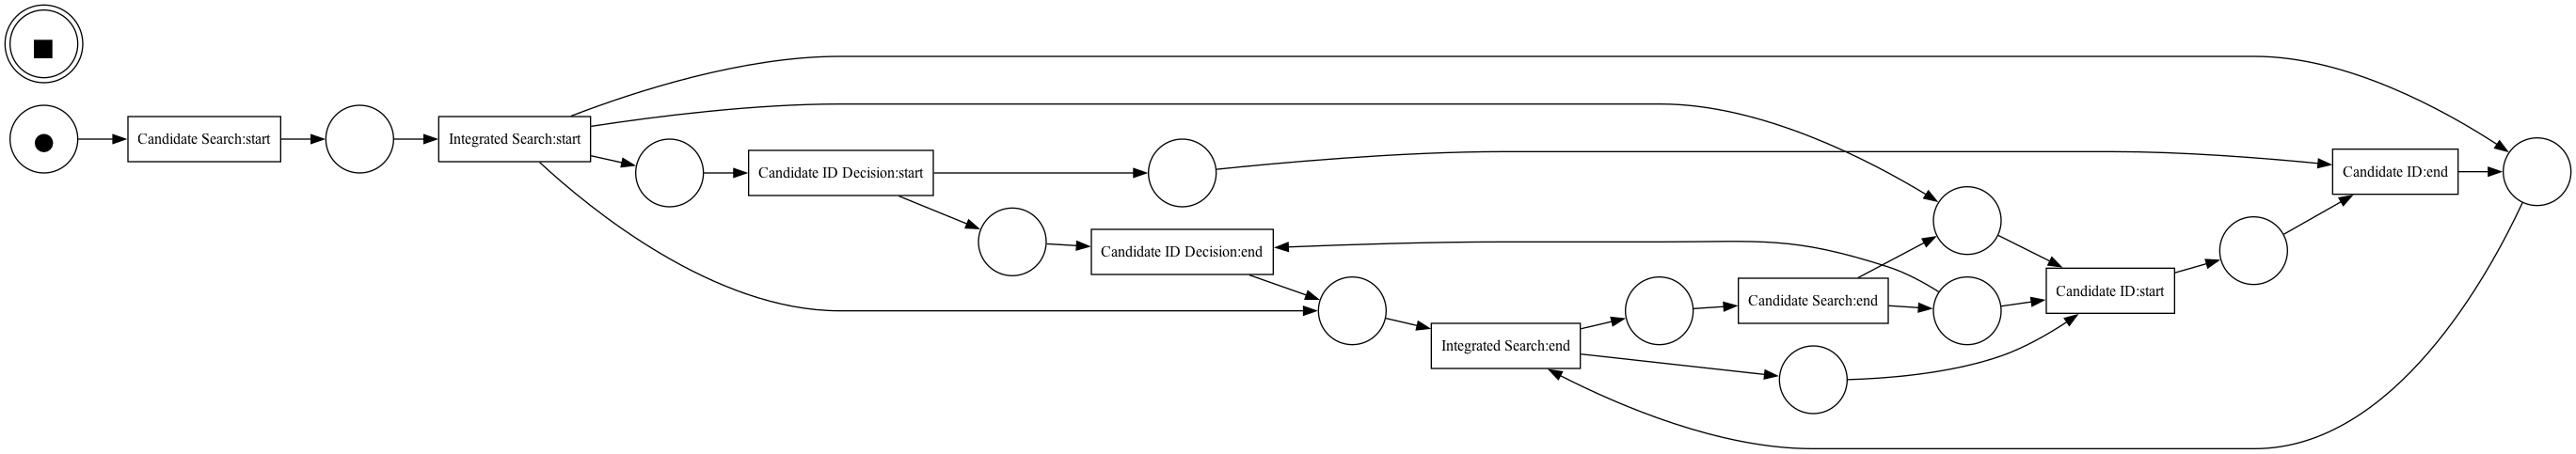

In [64]:
from mine_utils import mine_alpha
mine_alpha(log3)

In [70]:
from variant_stats import get_variants_stats, get_covering_variants, filter_traces_on_variants

var_stats = get_variants_stats(log3)
var_stats

,sequence,cov_amt,cov_perc,cov_perc_cumul,var_perc_cumul
0,"(Candidate Search:start, Integrated Search:start, Candidate ID:start, Candidate ID Decision:start, Integrated Search:end, Candidate Search:end, Candidate ID:end, Candidate ID Decision:end)",508,36.363636,36.363636,7.142857
1,"(Candidate Search:start, Integrated Search:start, Integrated Search:end, Candidate Search:end, Candidate ID:start, Candidate ID Decision:start, Candidate ID:end, Candidate ID Decision:end)",428,30.637079,67.000716,14.285714
2,"(Candidate Search:start, Integrated Search:start, Integrated Search:end, Candidate ID:start, Candidate ID Decision:start, Candidate Search:end, Candidate ID:end, Candidate ID Decision:end)",333,23.836793,90.837509,21.428571
3,"(Candidate Search:start, Integrated Search:start, Candidate ID Decision:start, Integrated Search:end, Candidate Search:end, Candidate ID:start, Candidate ID:end, Candidate ID Decision:end)",64,4.581246,95.418754,28.571429
4,"(Candidate Search:start, Integrated Search:start, Integrated Search:end, Candidate Search:end, Candidate ID Decision:start, Candidate ID Decision:end)",27,1.932713,97.351467,35.714286
5,"(Candidate Search:start, Integrated Search:start, Integrated Search:end, Candidate Search:end, Candidate ID Decision:start, Candidate ID:start, Candidate ID:end, Candidate ID Decision:end)",8,0.572656,97.924123,42.857143
6,"(Candidate Search:start, Integrated Search:start, Candidate ID:start, Candidate ID Decision:start, Candidate ID:end, Integrated Search:end, Candidate Search:end, Candidate ID Decision:end)",7,0.501074,98.425197,50.000000
7,"(Candidate Search:start, Integrated Search:start, Integrated Search:end, Candidate ID:start, Candidate ID Decision:start, Candidate ID:end, Candidate Search:end, Candidate ID Decision:end)",6,0.429492,98.854689,57.142857
8,"(Candidate Search:start, Integrated Search:start, Integrated Search:end, Candidate ID Decision:start, Candidate Search:end, Candidate ID:start, Candidate ID:end, Candidate ID Decision:end)",5,0.357910,99.212598,64.285714
9,"(Candidate Search:start, Integrated Search:start, Integrated Search:end, Candidate Search:end, Candidate ID:start, Candidate ID Decision:start, Candidate ID Decision:end, Candidate ID:end)",4,0.286328,99.498926,71.428571


In [73]:
log3.to_csv("tmp.csv")
import pm4py.objects.log.exporter.xes.exporter as xes_export
xes_export.apply(log3, "tmp.xes")

/Users/wvw/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/wvw/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/wvw/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/wvw/anaconda3/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` 

exporting log, completed traces ::   0%|          | 0/1397 [00:00<?, ?it/s]

took subset of log with only 'candidate' & 'integrated' keywords
did frequent itemset mining to get frequent combinations of subset's events

in the end, simply considered all subset's events together
(was mucking about with individual pairs; if simult, ensuring a particular ordering. didn't make much difference & labor intensive.)

with all events taken together, they are "simulteneous" (within 10min) in 75% cases
eventually, removed all "simultaneous" events from the log to get "real" orderings
-> log3

after checking the discovered petri net & variants, it seemed the following holds, more or less:
cand search:start -> integr search:start -> integr search:end -> cand search:end
 										    cand id:start ~> cand id dec:start -> cand id:end ~> cand id dec:end

used declare miner (RuM tool) - it finds more or less the same constraints; especially when looking at the automaton
but a lot of the constraints are inferrable (transitivity) ... difficult to read
-> search-found-automaton, search-found-constraints

manually created a more minimal decl model based on the above
-> search-manual-loose (not fully compliant), search-manual-strict (full compliance)

unsure how to automatically find a minimal model
work by de smedt highlights implied dependencies (so, even more of them...)

In [ ]:
# does not consider multiple "groups" occurring per case

# max_time_delta = 10 * 60 * pow(10,9) # nano to seconds

# for idx, row in itemsets.iterrows():
#     itemset = row['itemsets']
#     print("itemset:", itemset)
    
#     # filter events to those in the itemset
#     log3 = log2[log2['concept:name'].isin(itemset)]
    
#     # per case, get time differences between itemset events
#     time_diff = log3.groupby('case:concept:name')['time:timestamp'].diff().astype(int)
#     # get those less than the max time delta
#     simult_evts = time_diff[(time_diff >= 0) & (time_diff <= max_time_delta)]
    
#     print("total # events:", log3.shape[0])
#     print("# simult evts:", len(simult_evts), "(", round(len(simult_evts)/log3.shape[0]*100, 2), "%)")
    
#     print()

itemset: frozenset({'Candidate Search:end', 'Candidate Search:start'})
total # events: 11492
# simult evts: 5350 ( 46.55 %)

itemset: frozenset({'Candidate ID Decision:start', 'Candidate Search:start'})
total # events: 11404
# simult evts: 5268 ( 46.19 %)

itemset: frozenset({'Candidate ID Decision:end', 'Candidate Search:start'})
total # events: 11404
# simult evts: 4254 ( 37.3 %)

itemset: frozenset({'Candidate ID:start', 'Candidate Search:start'})
total # events: 11369
# simult evts: 5268 ( 46.34 %)

itemset: frozenset({'Candidate ID:end', 'Candidate Search:start'})
total # events: 11369
# simult evts: 5237 ( 46.06 %)

itemset: frozenset({'Candidate Search:end', 'Candidate ID Decision:start'})
total # events: 11404
# simult evts: 5648 ( 49.53 %)

itemset: frozenset({'Candidate ID Decision:end', 'Candidate Search:end'})
total # events: 11404
# simult evts: 4593 ( 40.28 %)

itemset: frozenset({'Candidate ID:start', 'Candidate Search:end'})
total # events: 11369
# simult evts: 5613 ( 4

## Method 1: simult - frequent

In [ ]:
simult_evts = log.groupby(['case:concept:name', 'time:timestamp'])['concept:name'].apply(tuple)
simult_evts = simult_evts[map(lambda s: len(s)>1, simult_evts)]
simult_evts

In [ ]:
simult_evts.index = simult_evts.index.droplevel(level='time:timestamp')
simult_evts

In [ ]:
simult_evts_list = simult_evts.groupby(level=0).apply(tuple).to_list()
simult_evts_list[0]

In [ ]:
simult_evts[simult_evts.index=="1"]

In [ ]:
log[log['case:concept:name']=="1"]

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(simult_evts_list).transform(simult_evts_list)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

itemsets = apriori(df, min_support=0.1, use_colnames=True)
itemsets.sort_values(by='support', ascending=False).to_csv("tmp.csv")

In [ ]:
rules = association_rules(itemsets, metric ="lift", min_threshold = 1)
rules.sort_values(by='confidence', ascending=False)